# 센서 융합 (Sensor Fusion)

이 노트북에서는 자율주행을 위한 LiDAR와 카메라 센서 융합 기법에 대해 학습하고, 실제 데이터를 활용하여 멀티모달 센서 융합을 구현합니다.

## 학습 목표

- 센서 융합의 기본 개념과 필요성 이해
- 초기/중기/후기 융합 방식 비교 및 이해
- 데이터 레벨 융합과 특징 레벨 융합 구현
- LiDAR와 카메라 데이터 동기화 방법 학습
- RGB-D 데이터 생성 및 활용
- 멀티모달 특징 추출 및 융합 구현

## 1. 필요한 라이브러리 설치 및 임포트

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
from glob import glob
import open3d as o3d
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.calibration import (
    load_calib_data,
    lidar_to_camera,
    camera_to_image,
    lidar_to_image,
    get_fov_mask
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## 2. 센서 융합의 기본 개념과 필요성

자율주행 시스템에서는 다양한 센서를 활용하여 주변 환경을 인식합니다. 각 센서는 고유한 장단점을 가지고 있습니다:

### 센서별 특징

- **LiDAR**:
  - 장점: 정확한 거리 측정, 3D 구조 파악, 날씨/조명 영향 적음
  - 단점: 해상도 낮음, 색상 정보 없음, 비용 높음

- **카메라**:
  - 장점: 높은 해상도, 풍부한 색상 정보, 질감 인식, 저렴한 비용
  - 단점: 깊이 정보 부족, 조명/날씨 영향 큼, 거리 측정 어려움

- **레이더**:
  - 장점: 날씨 영향 적음, 속도 측정 가능, 장거리 감지
  - 단점: 낮은 해상도, 각도 정확도 낮음

### 센서 융합의 필요성

센서 융합은 다양한 센서의 장점을 결합하고 단점을 보완하여 환경 인식의 신뢰성과 정확성을 높이는 것을 목표로 합니다:

- **보완성**: 서로 다른 센서의 부족한 부분을 보완
- **중복성**: 여러 센서가 동일한 정보를 제공하여 신뢰성 향상
- **비용 효율성**: 고가의 센서와 저가의 센서 조합으로 성능과 비용 최적화
- **강인성**: 한 센서의 실패에도 시스템 작동 가능

## 3. 센서 융합 방식

센서 융합은 크게 다음과 같은 방식으로 나눌 수 있습니다:

### 융합 단계에 따른 분류

- **초기 융합 (Early Fusion)**:
  - 원시 데이터 수준에서 융합
  - 예: LiDAR 포인트를 카메라 이미지에 투영하여 RGB-D 데이터 생성

- **중기 융합 (Mid Fusion)**:
  - 특징 추출 후 특징 레벨에서 융합
  - 예: LiDAR와 카메라에서 각각 특징을 추출한 후 결합

- **후기 융합 (Late Fusion)**:
  - 각 센서에서 독립적으로 결정한 결과를 최종 단계에서 융합
  - 예: LiDAR와 카메라에서 각각 객체 검출 수행 후 결과 통합

### 구현 방식에 따른 분류

- **데이터 레벨 융합**: 센서 데이터를 직접 결합
- **특징 레벨 융합**: 각 센서에서 추출한 특징을 결합
- **결정 레벨 융합**: 각 센서에서 내린 결정을 통합


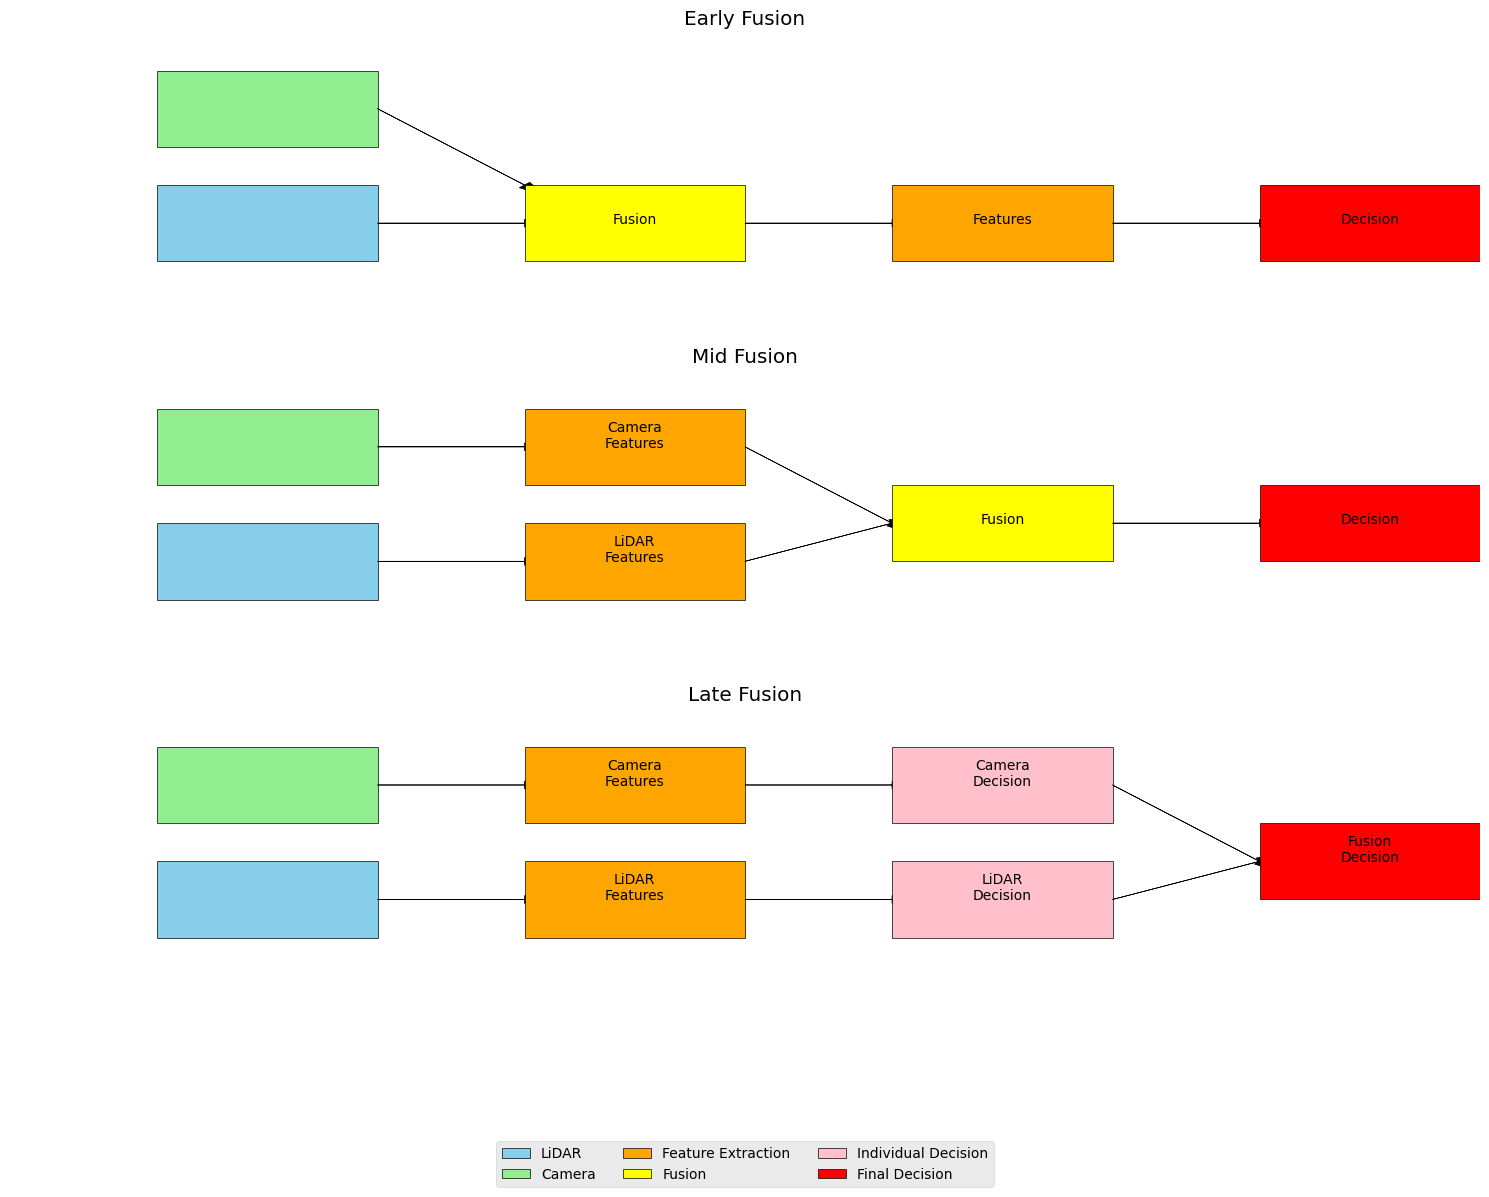

In [4]:
# 센서 융합 방식 개념도 시각화
def visualize_fusion_methods():
    """센서 융합 방식의 개념도를 시각화"""
    
    # 이미지 생성
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 초기 융합 (Early Fusion)
    ax = axes[0]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4)
    
    # 센서 박스
    ax.add_patch(plt.Rectangle((1, 1), 1.5, 1, fc='skyblue', ec='black', label='LiDAR'))
    ax.add_patch(plt.Rectangle((1, 2.5), 1.5, 1, fc='lightgreen', ec='black', label='Camera'))
    
    # 융합 흐름
    ax.arrow(2.5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(2.5, 3, 1, -1, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 융합 박스
    ax.add_patch(plt.Rectangle((3.5, 1), 1.5, 1, fc='yellow', ec='black'))
    ax.text(4.25, 1.5, 'Fusion', ha='center')
    
    # 처리 흐름
    ax.arrow(5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 특징 추출
    ax.add_patch(plt.Rectangle((6, 1), 1.5, 1, fc='orange', ec='black'))
    ax.text(6.75, 1.5, 'Features', ha='center')
    
    # 결정 흐름
    ax.arrow(7.5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 결정
    ax.add_patch(plt.Rectangle((8.5, 1), 1.5, 1, fc='red', ec='black'))
    ax.text(9.25, 1.5, 'Decision', ha='center')
    
    ax.set_title('Early Fusion')
    ax.set_axis_off()
    
    # 중기 융합 (Mid Fusion)
    ax = axes[1]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4)
    
    # 센서 박스
    ax.add_patch(plt.Rectangle((1, 1), 1.5, 1, fc='skyblue', ec='black', label='LiDAR'))
    ax.add_patch(plt.Rectangle((1, 2.5), 1.5, 1, fc='lightgreen', ec='black', label='Camera'))
    
    # 처리 흐름
    ax.arrow(2.5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(2.5, 3, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 특징 추출
    ax.add_patch(plt.Rectangle((3.5, 1), 1.5, 1, fc='orange', ec='black'))
    ax.text(4.25, 1.5, 'LiDAR\nFeatures', ha='center')
    ax.add_patch(plt.Rectangle((3.5, 2.5), 1.5, 1, fc='orange', ec='black'))
    ax.text(4.25, 3, 'Camera\nFeatures', ha='center')
    
    # 융합 흐름
    ax.arrow(5, 1.5, 1, 0.5, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(5, 3, 1, -1, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 융합 박스
    ax.add_patch(plt.Rectangle((6, 1.5), 1.5, 1, fc='yellow', ec='black'))
    ax.text(6.75, 2, 'Fusion', ha='center')
    
    # 결정 흐름
    ax.arrow(7.5, 2, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 결정
    ax.add_patch(plt.Rectangle((8.5, 1.5), 1.5, 1, fc='red', ec='black'))
    ax.text(9.25, 2, 'Decision', ha='center')
    
    ax.set_title('Mid Fusion')
    ax.set_axis_off()
    
    # 후기 융합 (Late Fusion)
    ax = axes[2]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4)
    
    # 센서 박스
    ax.add_patch(plt.Rectangle((1, 1), 1.5, 1, fc='skyblue', ec='black', label='LiDAR'))
    ax.add_patch(plt.Rectangle((1, 2.5), 1.5, 1, fc='lightgreen', ec='black', label='Camera'))
    
    # 처리 흐름
    ax.arrow(2.5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(2.5, 3, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 특징 추출
    ax.add_patch(plt.Rectangle((3.5, 1), 1.5, 1, fc='orange', ec='black'))
    ax.text(4.25, 1.5, 'LiDAR\nFeatures', ha='center')
    ax.add_patch(plt.Rectangle((3.5, 2.5), 1.5, 1, fc='orange', ec='black'))
    ax.text(4.25, 3, 'Camera\nFeatures', ha='center')
    
    # 결정 흐름
    ax.arrow(5, 1.5, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(5, 3, 1, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 개별 결정
    ax.add_patch(plt.Rectangle((6, 1), 1.5, 1, fc='pink', ec='black'))
    ax.text(6.75, 1.5, 'LiDAR\nDecision', ha='center')
    ax.add_patch(plt.Rectangle((6, 2.5), 1.5, 1, fc='pink', ec='black'))
    ax.text(6.75, 3, 'Camera\nDecision', ha='center')
    
    # 융합 흐름
    ax.arrow(7.5, 1.5, 1, 0.5, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(7.5, 3, 1, -1, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # 융합된 결정
    ax.add_patch(plt.Rectangle((8.5, 1.5), 1.5, 1, fc='red', ec='black'))
    ax.text(9.25, 2, 'Fusion\nDecision', ha='center')
    
    ax.set_title('Late Fusion')
    ax.set_axis_off()
    
    # 범례 추가
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', ec='black', label='LiDAR'),
        plt.Rectangle((0, 0), 1, 1, fc='lightgreen', ec='black', label='Camera'),
        plt.Rectangle((0, 0), 1, 1, fc='orange', ec='black', label='Feature Extraction'),
        plt.Rectangle((0, 0), 1, 1, fc='yellow', ec='black', label='Fusion'),
        plt.Rectangle((0, 0), 1, 1, fc='pink', ec='black', label='Individual Decision'),
        plt.Rectangle((0, 0), 1, 1, fc='red', ec='black', label='Final Decision')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# 센서 융합 방식 시각화
visualize_fusion_methods()


## 4. 데이터 로드

KITTI 데이터셋에서 LiDAR 포인트 클라우드, 카메라 이미지, 캘리브레이션 파일을 로드합니다.

/home/shbyun/KITTI/ObjectDetection/data_object_velodyne/training/velodyne/000000.bin
/home/shbyun/KITTI/ObjectDetection/data_object_image_2/training/image_2/000000.png
/home/shbyun/KITTI/ObjectDetection/data_object_calib/training/calib/000000.txt
포인트 클라우드 로드 완료: (115384, 4)
이미지 로드 완료: (370, 1224, 3)
캘리브레이션 데이터 로드 완료: ['P0', 'P1', 'P2', 'P3', 'R0_rect', 'Tr_velo_to_cam', 'Tr_imu_to_velo', 'velo_to_cam_rect']


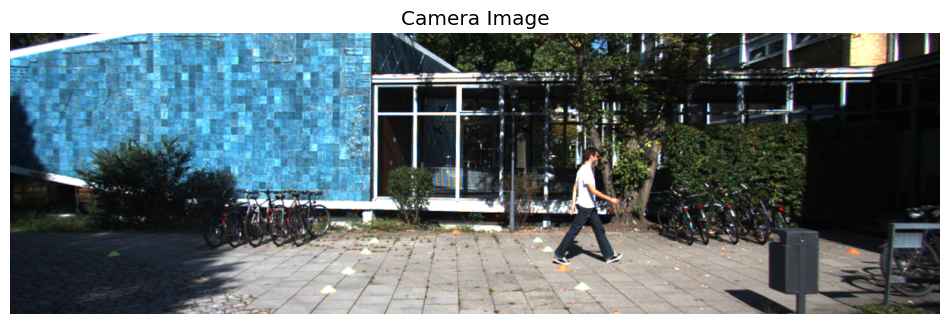

포인트 개수: 115384
X 범위: [-71.04, 73.04]
Y 범위: [-21.10, 53.80]
Z 범위: [-5.16, 2.67]
강도 범위: [0.00, 0.99]


In [5]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

# 데이터 경로 설정
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
image_dir = os.path.join(data_dir, 'data_object_image_2/training', 'image_2')
calib_dir = os.path.join(data_dir, 'data_object_calib/training', 'calib')

# 첫 번째 프레임 로드
frame_id = '000000'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
image_path = os.path.join(image_dir, f'{frame_id}.png')
calib_path = os.path.join(calib_dir, f'{frame_id}.txt')

print(point_cloud_path)
print(image_path)
print(calib_path)

# 데이터 로드
if os.path.exists(point_cloud_path) and os.path.exists(image_path) and os.path.exists(calib_path):
    points = load_point_cloud(point_cloud_path)
    image = load_image(image_path)
    calib_data = load_calib_data(calib_path)
    
    print(f"포인트 클라우드 로드 완료: {points.shape}")
    print(f"이미지 로드 완료: {image.shape}")
    print(f"캘리브레이션 데이터 로드 완료: {list(calib_data.keys())}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print("경로에 KITTI 데이터가 없습니다. 예시 데이터를 생성합니다...")
    
    # 예시 포인트 클라우드 생성
    num_points = 10000
    x = np.random.uniform(-20, 20, num_points)
    y = np.random.uniform(-20, 20, num_points)
    z = np.random.uniform(-2, 5, num_points)
    intensity = np.random.uniform(0, 1, num_points)
    points = np.column_stack((x, y, z, intensity))
    
    # 예시 이미지 생성 (검은 배경에 그리드)
    image = np.zeros((375, 1242, 3), dtype=np.uint8)
    for i in range(0, image.shape[0], 50):
        cv2.line(image, (0, i), (image.shape[1], i), (50, 50, 50), 1)
    for i in range(0, image.shape[1], 50):
        cv2.line(image, (i, 0), (i, image.shape[0]), (50, 50, 50), 1)
    
    # 렌덤 컬러 사각형 추가
    for _ in range(5):
        x1 = np.random.randint(0, image.shape[1] - 100)
        y1 = np.random.randint(0, image.shape[0] - 100)
        w = np.random.randint(50, 150)
        h = np.random.randint(50, 150)
        color = np.random.randint(0, 255, 3).tolist()
        cv2.rectangle(image, (x1, y1), (x1+w, y1+h), color, -1)
    
    # 예시 캘리브레이션 데이터 생성
    calib_data = {
        'P2': np.array([
            [721.5377, 0.0, 609.5593, 44.85728],
            [0.0, 721.5377, 172.854, 0.2163791],
            [0.0, 0.0, 1.0, 0.002745884]
        ]),
        'R0_rect': np.eye(3),
        'Tr_velo_to_cam': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
            [0.0, 0.0, 0.0, 1.0]
        ])
    }
    
    print(f"예시 포인트 클라우드 생성 완료: {points.shape}")
    print(f"예시 이미지 생성 완료: {image.shape}")
    print(f"예시 캘리브레이션 데이터 생성 완료")

# 데이터 시각화
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.title('Camera Image')
plt.axis('off')
plt.show()

# 포인트 클라우드 통계
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")

## 5. 초기 융합 (Early Fusion) - RGB-D 데이터 생성

LiDAR 포인트 클라우드와 카메라 이미지를 조합하여 RGB-D 데이터를 생성합니다. 각 픽셀에 색상 정보(RGB)와 깊이 정보(D)를 모두 갖는 형태입니다.


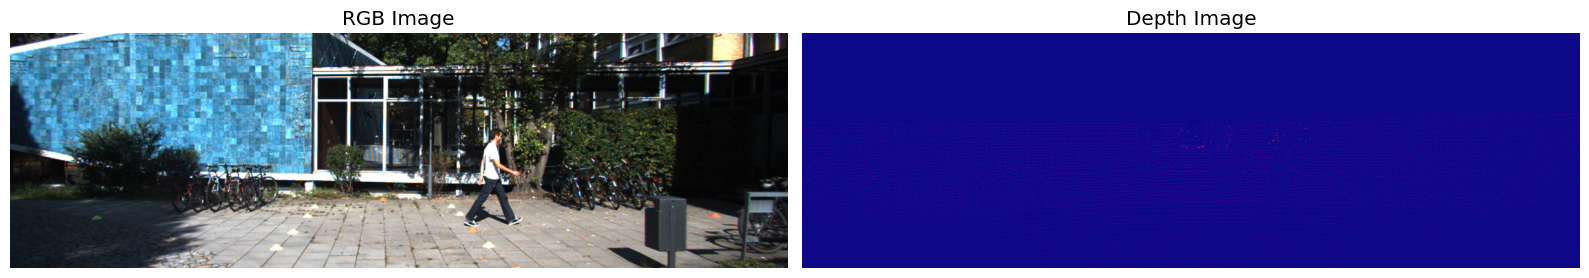

In [6]:
def generate_rgbd_data(points, image, calib_data, max_depth=100.0):
    """
    LiDAR 포인트 클라우드와 카메라 이미지를 융합하여 RGB-D 데이터 생성
    
    Args:
        points (numpy.ndarray): LiDAR 포인트 클라우드 [N, 4] (x, y, z, intensity)
        image (numpy.ndarray): RGB 이미지
        calib_data (dict): 캘리브레이션 데이터
        max_depth (float): 최대 깊이 값
        
    Returns:
        tuple: (RGB-D 이미지, 깊이 이미지)
    """
    # 이미지 크기 가져오기
    height, width = image.shape[:2]
    
    # 깊이 이미지 초기화 (모든 값 무한대로 설정)
    depth_image = np.full((height, width), np.inf, dtype=np.float32)
    
    # LiDAR에서 이미지로 투영
    points_img, points_cam = lidar_to_image(points, calib_data)
    
    # 이미지 범위 내 포인트 필터링
    fov_mask = get_fov_mask(points_img, points_cam, (height, width))
    points_img_fov = points_img[fov_mask].astype(int)
    points_cam_fov = points_cam[fov_mask]
    
    # 깊이 값 (Z) 추출
    depths = points_cam_fov[:, 2]
    
    # 깊이 이미지 생성 (각 픽셀에 대해 가장 가까운 포인트의 깊이 사용)
    for i, (u, v) in enumerate(points_img_fov):
        if 0 <= u < width and 0 <= v < height:
            # 현재 저장된 깊이보다 더 가까우면 업데이트
            if depths[i] < depth_image[v, u]:
                depth_image[v, u] = depths[i]
    
    # RGB-D 이미지 생성 (RGB 채널 + 깊이 채널)
    rgbd_image = np.dstack((image, depth_image))
    
    # 깊이 이미지 시각화를 위해 정규화
    depth_viz = depth_image.copy()
    mask = depth_viz != np.inf
    if np.sum(mask) > 0:  # 유효한 깊이 값이 있는 경우
        depth_viz[~mask] = 0  # 무한대 값을 0으로 설정
        depth_viz[mask] = np.clip(depth_viz[mask], 0, max_depth)  # 최대 깊이 제한
        depth_viz = depth_viz / max_depth * 255  # 0-255 범위로 정규화
    
    depth_viz = depth_viz.astype(np.uint8)
    
    return rgbd_image, depth_viz

# RGB-D 데이터 생성
rgbd_image, depth_viz = generate_rgbd_data(points, image, calib_data)

# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RGB 이미지
axes[0].imshow(image)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# 깊이 이미지
depth_colored = cv2.applyColorMap(depth_viz, cv2.COLORMAP_PLASMA)
depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)
axes[1].imshow(depth_colored)
axes[1].set_title('Depth Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 6. RGB-D 이미지에서 특징 추출

RGB-D 이미지에서 색상 정보와 깊이 정보를 모두 활용하여 특징을 추출합니다.

In [7]:
def extract_rgbd_features(rgb_image, depth_image, block_size=16):
    """
    RGB-D 이미지에서 색상과 깊이 특징 추출
    
    Args:
        rgb_image (numpy.ndarray): RGB 이미지
        depth_image (numpy.ndarray): 깊이 이미지
        block_size (int): 특징 추출을 위한 블록 크기
        
    Returns:
        numpy.ndarray: 추출된 특징 벡터 [N, D]
    """
    height, width = rgb_image.shape[:2]
    
    # 결과 특징 벡터를 저장할 리스트
    features = []
    
    # 이미지를 블록으로 분할하여 처리
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            # 블록 경계 설정
            y_end = min(y + block_size, height)
            x_end = min(x + block_size, width)
            
            # 블록 추출
            rgb_block = rgb_image[y:y_end, x:x_end]
            depth_block = depth_image[y:y_end, x:x_end]
            
            # 유효한 깊이 값 마스크 (무한대가 아닌 값)
            depth_mask = depth_block != np.inf
            
            # RGB 특징 (평균 색상)
            rgb_mean = np.mean(rgb_block, axis=(0, 1))
            
            # 깊이 특징
            if np.sum(depth_mask) > 0:
                depth_mean = np.mean(depth_block[depth_mask])
                depth_std = np.std(depth_block[depth_mask])
            else:
                depth_mean = 0
                depth_std = 0
            
            # RGB와 깊이 특징 결합
            block_feature = np.concatenate([rgb_mean, [depth_mean, depth_std]])
            
            # 중심 좌표 추가
            center_x = (x + x_end) / 2 / width
            center_y = (y + y_end) / 2 / height
            
            # 최종 특징 벡터
            feature = np.concatenate([block_feature, [center_x, center_y]])
            
            features.append(feature)
    
    return np.array(features)

# RGB 이미지와 깊이 이미지에서 특징 추출
rgb_features = extract_rgbd_features(image, rgbd_image[:, :, 3], block_size=32)

print(f"추출된 특징 개수: {len(rgb_features)}")
print(f"특징 벡터 차원: {rgb_features.shape[1]}")


추출된 특징 개수: 468
특징 벡터 차원: 7


## 7. 중기 융합 (Mid Fusion) - 특징 융합

LiDAR와 카메라에서 각각 추출한 특징을 융합하여 통합된 특징 벡터를 생성합니다.


In [8]:
def extract_lidar_features(points, calib_data, image_shape, grid_size=5.0, height_bins=10):
    """
    LiDAR 포인트 클라우드에서 특징 추출
    
    Args:
        points (numpy.ndarray): LiDAR 포인트 클라우드 [N, 4] (x, y, z, intensity)
        calib_data (dict): 캘리브레이션 데이터
        image_shape (tuple): 이미지 크기 (height, width)
        grid_size (float): 그리드 셀 크기 (미터)
        height_bins (int): 높이 히스토그램 빈 개수
        
    Returns:
        numpy.ndarray: 추출된 LiDAR 특징 [M, D]
    """
    # 이미지 평면으로 투영
    points_img, points_cam = lidar_to_image(points, calib_data)
    
    # 이미지 범위 내 포인트 필터링
    fov_mask = get_fov_mask(points_img, points_cam, image_shape)
    points_fov = points[fov_mask]
    points_cam_fov = points_cam[fov_mask]
    
    # 바닥면(XY) 그리드 생성
    x_min, x_max = np.min(points_fov[:, 0]), np.max(points_fov[:, 0])
    y_min, y_max = np.min(points_fov[:, 1]), np.max(points_fov[:, 1])
    
    # 그리드 인덱스 계산을 위한 경계 조정
    x_min = np.floor(x_min / grid_size) * grid_size
    y_min = np.floor(y_min / grid_size) * grid_size
    x_max = np.ceil(x_max / grid_size) * grid_size
    y_max = np.ceil(y_max / grid_size) * grid_size
    
    # 그리드 차원 계산
    num_x_cells = int((x_max - x_min) / grid_size)
    num_y_cells = int((y_max - y_min) / grid_size)
    
    # 그리드가 너무 작으면 조정
    if num_x_cells < 2:
        num_x_cells = 2
        x_max = x_min + grid_size * num_x_cells
    if num_y_cells < 2:
        num_y_cells = 2
        y_max = y_min + grid_size * num_y_cells
    
    # 높이 범위 계산
    z_min, z_max = np.min(points_fov[:, 2]), np.max(points_fov[:, 2])
    
    # 특징 저장을 위한 리스트
    lidar_features = []
    
    # 각 그리드 셀에 대해 특징 추출
    for i in range(num_x_cells):
        for j in range(num_y_cells):
            # 그리드 셀 경계
            cell_x_min = x_min + i * grid_size
            cell_x_max = x_min + (i + 1) * grid_size
            cell_y_min = y_min + j * grid_size
            cell_y_max = y_min + (j + 1) * grid_size
            
            # 셀 내 포인트 필터링
            cell_mask = (
                (points_fov[:, 0] >= cell_x_min) & (points_fov[:, 0] < cell_x_max) &
                (points_fov[:, 1] >= cell_y_min) & (points_fov[:, 1] < cell_y_max)
            )
            cell_points = points_fov[cell_mask]
            
            if len(cell_points) > 0:
                # 기본 통계 특징
                mean_z = np.mean(cell_points[:, 2])
                std_z = np.std(cell_points[:, 2])
                mean_intensity = np.mean(cell_points[:, 3])
                std_intensity = np.std(cell_points[:, 3])
                point_density = len(cell_points) / (grid_size * grid_size)
                
                # 높이 히스토그램
                hist, _ = np.histogram(cell_points[:, 2], bins=height_bins, range=(z_min, z_max))
                hist = hist / (np.sum(hist) + 1e-10)  # 정규화
                
                # 셀 중심 좌표 (정규화)
                center_x = (cell_x_min + cell_x_max) / 2
                center_y = (cell_y_min + cell_y_max) / 2
                
                # 특징 벡터 결합
                feature = np.concatenate([
                    [mean_z, std_z, mean_intensity, std_intensity, point_density, center_x, center_y],
                    hist
                ])
                
                lidar_features.append(feature)
    
    return np.array(lidar_features)

# 중기 융합 모델 정의 (간단한 MLP)
class MidFusionMLP(nn.Module):
    def __init__(self, camera_dim, lidar_dim, hidden_dim=64, output_dim=32):
        super(MidFusionMLP, self).__init__()
        
        # 카메라 브랜치
        self.camera_branch = nn.Sequential(
            nn.Linear(camera_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # LiDAR 브랜치
        self.lidar_branch = nn.Sequential(
            nn.Linear(lidar_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # 융합 브랜치
        self.fusion_branch = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, camera_features, lidar_features):
        # 카메라 특징 처리
        camera_out = self.camera_branch(camera_features)
        
        # LiDAR 특징 처리
        lidar_out = self.lidar_branch(lidar_features)
        
        # 특징 융합 (단순 연결)
        fused = torch.cat([camera_out, lidar_out], dim=1)
        
        # 융합된 특징 처리
        output = self.fusion_branch(fused)
        
        return output

# LiDAR 특징 추출
lidar_features = extract_lidar_features(points, calib_data, image.shape[:2], grid_size=5.0)

print(f"LiDAR 특징 개수: {len(lidar_features)}")
print(f"LiDAR 특징 차원: {lidar_features.shape[1]}")
print(f"카메라 특징 개수: {len(rgb_features)}")
print(f"카메라 특징 차원: {rgb_features.shape[1]}")

# 시뮬레이션을 위해 동일한 수의 샘플만 사용
min_samples = min(len(rgb_features), len(lidar_features))
rgb_features_sample = rgb_features[:min_samples]
lidar_features_sample = lidar_features[:min_samples]

# PyTorch 텐서로 변환
camera_tensor = torch.FloatTensor(rgb_features_sample)
lidar_tensor = torch.FloatTensor(lidar_features_sample)

# 중기 융합 모델 초기화
mid_fusion_model = MidFusionMLP(
    camera_dim=rgb_features.shape[1],
    lidar_dim=lidar_features.shape[1],
    hidden_dim=64,
    output_dim=32
)

# 모델 순전파 시연
fused_features = mid_fusion_model(camera_tensor, lidar_tensor)

print(f"융합된 특징 텐서 크기: {fused_features.shape}")
print(f"샘플 융합 특징: {fused_features[0][:5]}")  # 첫 번째 샘플의 처음 5개 요소


LiDAR 특징 개수: 36
LiDAR 특징 차원: 17
카메라 특징 개수: 468
카메라 특징 차원: 7
융합된 특징 텐서 크기: torch.Size([36, 32])
샘플 융합 특징: tensor([-1.7211, -0.2407, -2.1727,  0.0998,  0.2158], grad_fn=<SliceBackward0>)


## 8. 후기 융합 (Late Fusion) - 결정 융합

LiDAR와 카메라에서 각각 독립적으로 수행한 분류 또는 탐지 결과를 융합합니다.


카메라 검출 수: 8
LiDAR 검출 수: 10
융합 검출 수: 11


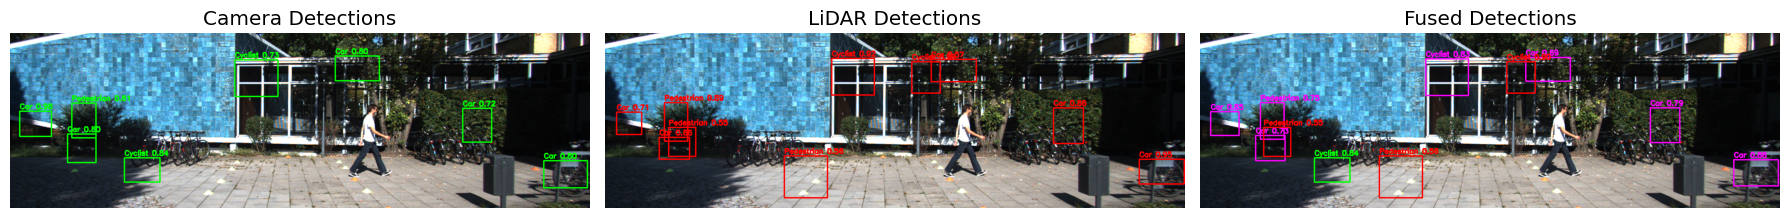

In [9]:
def simulate_object_detection(num_objects=10, img_width=1242, img_height=375, seed=42):
    """
    객체 검출 결과 시뮬레이션
    
    Args:
        num_objects (int): 생성할 객체 수
        img_width (int): 이미지 너비
        img_height (int): 이미지 높이
        seed (int): 랜덤 시드
        
    Returns:
        tuple: (카메라 검출 결과, LiDAR 검출 결과)
    """
    np.random.seed(seed)
    
    # 객체 클래스
    classes = ['Car', 'Pedestrian', 'Cyclist']
    
    # 카메라 검출 결과 생성
    camera_detections = []
    for i in range(num_objects):
        # 무작위 경계 상자
        x1 = np.random.randint(0, img_width - 100)
        y1 = np.random.randint(0, img_height - 100)
        w = np.random.randint(50, 100)
        h = np.random.randint(50, 100)
        
        # 무작위 클래스 및 신뢰도
        class_id = np.random.randint(0, len(classes))
        confidence = np.random.uniform(0.5, 1.0)
        
        # 각 객체에 고유 ID 부여
        object_id = i
        
        camera_detections.append({
            'box': [x1, y1, x1+w, y1+h],
            'class': classes[class_id],
            'confidence': confidence,
            'id': object_id
        })
    
    # LiDAR 검출 결과 생성 (일부 카메라 검출과 일치, 일부는 새로운 검출)
    lidar_detections = []
    
    # 카메라 검출과 일치하는 일부 객체
    for i in range(min(7, num_objects)):
        camera_det = camera_detections[i].copy()
        
        # 약간의 변동 추가
        box = camera_det['box']
        box = [
            max(0, box[0] + np.random.randint(-10, 10)),
            max(0, box[1] + np.random.randint(-10, 10)),
            min(img_width, box[2] + np.random.randint(-10, 10)),
            min(img_height, box[3] + np.random.randint(-10, 10))
        ]
        
        # 신뢰도 변경
        confidence = np.random.uniform(0.5, 1.0)
        
        lidar_detections.append({
            'box': box,
            'class': camera_det['class'],
            'confidence': confidence,
            'id': camera_det['id']
        })
    
    # 새로운 LiDAR 검출 추가
    for i in range(3):
        # 무작위 경계 상자
        x1 = np.random.randint(0, img_width - 100)
        y1 = np.random.randint(0, img_height - 100)
        w = np.random.randint(50, 100)
        h = np.random.randint(50, 100)
        
        # 무작위 클래스 및 신뢰도
        class_id = np.random.randint(0, len(classes))
        confidence = np.random.uniform(0.5, 1.0)
        
        # 새로운 ID 부여
        object_id = num_objects + i
        
        lidar_detections.append({
            'box': [x1, y1, x1+w, y1+h],
            'class': classes[class_id],
            'confidence': confidence,
            'id': object_id
        })
    
    return camera_detections, lidar_detections

def compute_iou(box1, box2):
    """
    두 경계 상자 간의 IoU(Intersection over Union) 계산
    
    Args:
        box1 (list): 첫 번째 경계 상자 [x1, y1, x2, y2]
        box2 (list): 두 번째 경계 상자 [x1, y1, x2, y2]
        
    Returns:
        float: IoU 값
    """
    # 교차 영역 계산
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # 각 경계 상자 영역 계산
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # IoU 계산
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

def late_fusion(camera_detections, lidar_detections, iou_threshold=0.5):
    """
    카메라와 LiDAR 검출 결과를 융합 (후기 융합)
    
    Args:
        camera_detections (list): 카메라 검출 결과 리스트
        lidar_detections (list): LiDAR 검출 결과 리스트
        iou_threshold (float): 동일 객체로 판단하는 IoU 임계값
        
    Returns:
        list: 융합된 검출 결과
    """
    fused_detections = []
    used_camera_indices = set()
    used_lidar_indices = set()
    
    # 각 카메라 검출에 대해 가장 일치하는 LiDAR 검출 찾기
    for i, camera_det in enumerate(camera_detections):
        camera_box = camera_det['box']
        best_iou = 0
        best_match = -1
        
        for j, lidar_det in enumerate(lidar_detections):
            lidar_box = lidar_det['box']
            iou = compute_iou(camera_box, lidar_box)
            
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        # 충분히 일치하는 LiDAR 검출이 있는 경우 융합
        if best_iou > iou_threshold:
            lidar_det = lidar_detections[best_match]
            
            # 신뢰도 가중 평균 (일반적으로 각 센서의 특성에 따라 가중치를 다르게 설정)
            fused_confidence = 0.5 * camera_det['confidence'] + 0.5 * lidar_det['confidence']
            
            # 클래스가 다른 경우 더 높은 신뢰도의 클래스 선택
            if camera_det['class'] != lidar_det['class']:
                fused_class = camera_det['class'] if camera_det['confidence'] > lidar_det['confidence'] else lidar_det['class']
            else:
                fused_class = camera_det['class']
            
            # IoU 기반으로 박스 위치 융합
            fused_box = [
                (camera_det['box'][0] + lidar_det['box'][0]) / 2,
                (camera_det['box'][1] + lidar_det['box'][1]) / 2,
                (camera_det['box'][2] + lidar_det['box'][2]) / 2,
                (camera_det['box'][3] + lidar_det['box'][3]) / 2
            ]
            
            fused_detections.append({
                'box': fused_box,
                'class': fused_class,
                'confidence': fused_confidence,
                'id': camera_det['id'],
                'source': 'both',
                'camera_confidence': camera_det['confidence'],
                'lidar_confidence': lidar_det['confidence']
            })
            
            used_camera_indices.add(i)
            used_lidar_indices.add(best_match)
        
    # 매칭되지 않은 카메라 검출 추가
    for i, camera_det in enumerate(camera_detections):
        if i not in used_camera_indices:
            camera_det_copy = camera_det.copy()
            camera_det_copy['source'] = 'camera'
            camera_det_copy['camera_confidence'] = camera_det['confidence']
            camera_det_copy['lidar_confidence'] = 0.0
            fused_detections.append(camera_det_copy)
    
    # 매칭되지 않은 LiDAR 검출 추가
    for i, lidar_det in enumerate(lidar_detections):
        if i not in used_lidar_indices:
            lidar_det_copy = lidar_det.copy()
            lidar_det_copy['source'] = 'lidar'
            lidar_det_copy['camera_confidence'] = 0.0
            lidar_det_copy['lidar_confidence'] = lidar_det['confidence']
            fused_detections.append(lidar_det_copy)
    
    return fused_detections

# 객체 검출 결과 시뮬레이션
camera_detections, lidar_detections = simulate_object_detection(num_objects=8)

# 후기 융합 적용
fused_detections = late_fusion(camera_detections, lidar_detections, iou_threshold=0.3)

print(f"카메라 검출 수: {len(camera_detections)}")
print(f"LiDAR 검출 수: {len(lidar_detections)}")
print(f"융합 검출 수: {len(fused_detections)}")

# 검출 결과 시각화
def visualize_detections(image, camera_detections, lidar_detections, fused_detections):
    """검출 결과 시각화"""
    # 이미지 복사
    camera_img = image.copy()
    lidar_img = image.copy()
    fused_img = image.copy()
    
    # 카메라 검출 시각화
    for det in camera_detections:
        box = det['box']
        box = [int(x) for x in box]
        cv2.rectangle(camera_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        label = f"{det['class']} {det['confidence']:.2f}"
        cv2.putText(camera_img, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # LiDAR 검출 시각화
    for det in lidar_detections:
        box = det['box']
        box = [int(x) for x in box]
        cv2.rectangle(lidar_img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        label = f"{det['class']} {det['confidence']:.2f}"
        cv2.putText(lidar_img, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # 융합 검출 시각화
    for det in fused_detections:
        box = det['box']
        box = [int(x) for x in box]
        
        # 소스에 따라 색상 설정
        if det['source'] == 'both':
            color = (255, 0, 255)  # 마젠타
        elif det['source'] == 'camera':
            color = (0, 255, 0)    # 초록
        else:  # 'lidar'
            color = (255, 0, 0)    # 빨강
            
        cv2.rectangle(fused_img, (box[0], box[1]), (box[2], box[3]), color, 2)
        label = f"{det['class']} {det['confidence']:.2f}"
        cv2.putText(fused_img, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # 결과 표시
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(camera_img)
    axes[0].set_title('Camera Detections')
    axes[0].axis('off')
    
    axes[1].imshow(lidar_img)
    axes[1].set_title('LiDAR Detections')
    axes[1].axis('off')
    
    axes[2].imshow(fused_img)
    axes[2].set_title('Fused Detections')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 검출 결과 시각화
visualize_detections(image, camera_detections, lidar_detections, fused_detections)


## 9. 고급: 3D-2D 융합 파이프라인

LiDAR 기반 3D 객체 검출과 카메라 기반 2D 객체 검출을 융합하는 파이프라인을 구현합니다.

3D 검출 수: 6
이미지에 투영된 3D 검출 수: 0
2D 검출 수: 8
융합된 검출 수: 8


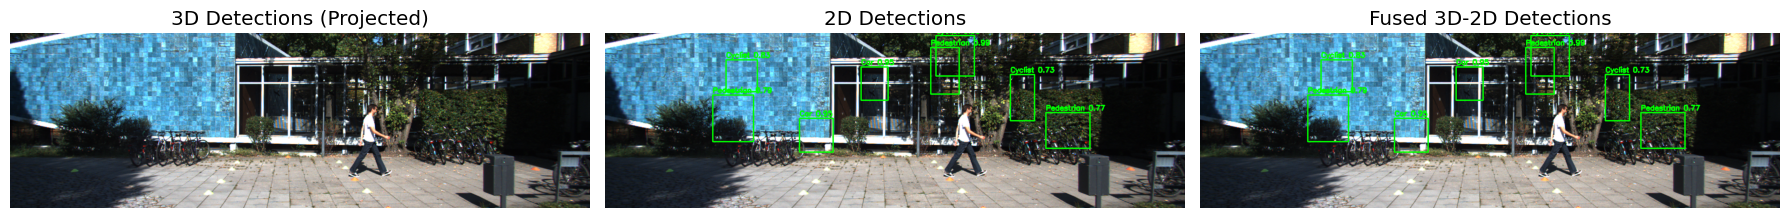

In [10]:
def simulate_3d_detections(num_objects=5, seed=42):
    """
    3D 객체 검출 결과 시뮬레이션
    
    Args:
        num_objects (int): 생성할 객체 수
        seed (int): 랜덤 시드
        
    Returns:
        list: 3D 객체 검출 결과
    """
    np.random.seed(seed)
    
    # 객체 클래스
    classes = ['Car', 'Pedestrian', 'Cyclist']
    
    # 3D 객체 검출 결과 생성
    detections_3d = []
    
    for i in range(num_objects):
        # 무작위 3D 위치 (x, y, z)
        x = np.random.uniform(-10, 10)
        y = np.random.uniform(5, 30)
        z = np.random.uniform(-1, 1)
        
        # 무작위 3D 크기 (length, width, height)
        if np.random.rand() < 0.7:  # Car
            length = np.random.uniform(3.5, 5.0)
            width = np.random.uniform(1.5, 2.0)
            height = np.random.uniform(1.4, 1.8)
            class_name = 'Car'
        elif np.random.rand() < 0.5:  # Pedestrian
            length = np.random.uniform(0.4, 0.8)
            width = np.random.uniform(0.4, 0.8)
            height = np.random.uniform(1.4, 1.9)
            class_name = 'Pedestrian'
        else:  # Cyclist
            length = np.random.uniform(1.0, 1.8)
            width = np.random.uniform(0.5, 0.8)
            height = np.random.uniform(1.4, 1.9)
            class_name = 'Cyclist'
        
        # 무작위 방향 (yaw 각도)
        yaw = np.random.uniform(-np.pi, np.pi)
        
        # 신뢰도
        confidence = np.random.uniform(0.5, 1.0)
        
        detections_3d.append({
            'id': i,
            'position': np.array([x, y, z]),
            'dimensions': np.array([length, width, height]),
            'yaw': yaw,
            'class': class_name,
            'confidence': confidence
        })
    
    return detections_3d

def project_3d_to_2d(detections_3d, calib_data, image_shape):
    """
    3D 검출 결과를 이미지 평면에 투영
    
    Args:
        detections_3d (list): 3D 객체 검출 결과
        calib_data (dict): 캘리브레이션 데이터
        image_shape (tuple): 이미지 크기 (height, width)
        
    Returns:
        list: 2D 경계 상자가 추가된 검출 결과
    """
    height, width = image_shape
    results = []
    
    for det in detections_3d:
        # 객체 중심점과 크기
        pos = det['position']
        dims = det['dimensions']
        yaw = det['yaw']
        
        # 3D 바운딩 박스의 8개 코너 계산
        # 바운딩 박스는 차량 좌표계에서 정의됨 (z-up, x-forward, y-left)
        l, w, h = dims
        
        # 바운딩 박스 코너 (차량 좌표계)
        corners_3d = np.array([
            [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
            [0, 0, 0, 0, h, h, h, h]
        ])
        
        # 회전 변환 (yaw 회전)
        R = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])
        
        # 회전 적용
        corners_3d = R @ corners_3d
        
        # 위치 이동
        corners_3d[0, :] += pos[0]
        corners_3d[1, :] += pos[1]
        corners_3d[2, :] += pos[2]
        
        # LiDAR 좌표계에서 카메라 좌표계로 변환
        corners_cam = np.zeros_like(corners_3d)
        for i in range(8):
            point_lidar = np.append(corners_3d[:, i], 1)
            point_cam = calib_data['Tr_velo_to_cam'] @ point_lidar
            corners_cam[:, i] = point_cam[:3]
        
        # 카메라 좌표계에서 이미지 평면으로 투영
        corners_img = np.zeros((2, 8))
        for i in range(8):
            point_cam = corners_cam[:, i]
            point_img = camera_to_image(np.array([point_cam]), calib_data)[0]
            corners_img[:, i] = point_img
        
        # 이미지 평면 내 코너만 필터링
        valid_corners = []
        for i in range(8):
            x, y = corners_img[:, i]
            if 0 <= x < width and 0 <= y < height:
                valid_corners.append((x, y))
        
        # 유효한 코너가 충분히 있는 경우 2D 박스 계산
        if len(valid_corners) >= 2:
            valid_corners = np.array(valid_corners)
            min_x = np.min(valid_corners[:, 0])
            min_y = np.min(valid_corners[:, 1])
            max_x = np.max(valid_corners[:, 0])
            max_y = np.max(valid_corners[:, 1])
            
            # 2D 박스가 너무 작지 않은 경우에만 추가
            if max_x - min_x > 10 and max_y - min_y > 10:
                det_copy = det.copy()
                det_copy['2d_box'] = [min_x, min_y, max_x, max_y]
                results.append(det_copy)
    
    return results

def fuse_3d_2d_detections(detections_3d_projected, detections_2d, iou_threshold=0.5):
    """
    투영된 3D 검출과 2D 검출 결과를 융합
    
    Args:
        detections_3d_projected (list): 이미지 평면에 투영된 3D 검출 결과
        detections_2d (list): 2D 검출 결과
        iou_threshold (float): 동일 객체로 판단하는 IoU 임계값
        
    Returns:
        list: 융합된 검출 결과
    """
    fused_detections = []
    used_3d_indices = set()
    used_2d_indices = set()
    
    # 각 3D 검출에 대해 가장 일치하는 2D 검출 찾기
    for i, det_3d in enumerate(detections_3d_projected):
        if '2d_box' not in det_3d:
            continue
            
        box_3d = det_3d['2d_box']
        best_iou = 0
        best_match = -1
        
        for j, det_2d in enumerate(detections_2d):
            box_2d = det_2d['box']
            iou = compute_iou(box_3d, box_2d)
            
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        # 충분히 일치하는 2D 검출이 있는 경우 융합
        if best_iou > iou_threshold:
            det_2d = detections_2d[best_match]
            
            # 3D 정보는 3D 검출에서, 클래스 신뢰도는 가중 평균 사용
            fused_det = det_3d.copy()
            
            # 클래스가 다른 경우 신뢰도 비교
            if det_3d['class'] != det_2d['class']:
                if det_3d['confidence'] > det_2d['confidence']:
                    fused_class = det_3d['class']
                else:
                    fused_class = det_2d['class']
                    
                fused_det['class'] = fused_class
            
            # 신뢰도는 가중 평균으로 갱신
            fused_det['confidence'] = 0.7 * det_3d['confidence'] + 0.3 * det_2d['confidence']
            
            # 2D 경계 상자 위치 정보 반영 (IoU에 따라 가중치 부여)
            weight_3d = 0.7
            weight_2d = 0.3
            
            # IoU가 높을수록 2D 가중치를 높임
            if best_iou > 0.7:
                weight_3d = 0.3
                weight_2d = 0.7
            
            fused_det['2d_box'] = [
                weight_3d * box_3d[0] + weight_2d * det_2d['box'][0],
                weight_3d * box_3d[1] + weight_2d * det_2d['box'][1],
                weight_3d * box_3d[2] + weight_2d * det_2d['box'][2],
                weight_3d * box_3d[3] + weight_2d * det_2d['box'][3]
            ]
            
            fused_det['source'] = 'both'
            fused_det['3d_confidence'] = det_3d['confidence']
            fused_det['2d_confidence'] = det_2d['confidence']
            
            fused_detections.append(fused_det)
            
            used_3d_indices.add(i)
            used_2d_indices.add(best_match)
        
    # 매칭되지 않은 3D 검출 추가
    for i, det_3d in enumerate(detections_3d_projected):
        if i not in used_3d_indices and '2d_box' in det_3d:
            det_copy = det_3d.copy()
            det_copy['source'] = '3d'
            det_copy['3d_confidence'] = det_3d['confidence']
            det_copy['2d_confidence'] = 0.0
            fused_detections.append(det_copy)
    
    # 매칭되지 않은 2D 검출 추가
    for i, det_2d in enumerate(detections_2d):
        if i not in used_2d_indices:
            det_copy = {
                'id': len(detections_3d_projected) + i,
                'class': det_2d['class'],
                'confidence': det_2d['confidence'],
                '2d_box': det_2d['box'],
                'source': '2d',
                '3d_confidence': 0.0,
                '2d_confidence': det_2d['confidence']
            }
            fused_detections.append(det_copy)
    
    return fused_detections

# 3D 검출 결과 시뮬레이션
detections_3d = simulate_3d_detections(num_objects=6)

# 3D 검출 결과를 이미지 평면에 투영
detections_3d_projected = project_3d_to_2d(detections_3d, calib_data, image.shape[:2])

# 2D 검출 결과 시뮬레이션 (일부는 3D 검출과 일치, 일부는 새로운 검출)
camera_detections, _ = simulate_object_detection(num_objects=8, seed=43)

# 3D-2D 융합
fused_3d_2d_detections = fuse_3d_2d_detections(detections_3d_projected, camera_detections, iou_threshold=0.3)

print(f"3D 검출 수: {len(detections_3d)}")
print(f"이미지에 투영된 3D 검출 수: {len(detections_3d_projected)}")
print(f"2D 검출 수: {len(camera_detections)}")
print(f"융합된 검출 수: {len(fused_3d_2d_detections)}")

# 3D-2D 융합 결과 시각화
def visualize_3d_2d_fusion(image, detections_3d_projected, detections_2d, fused_detections):
    """3D-2D 융합 결과 시각화"""
    # 이미지 복사
    img_3d = image.copy()
    img_2d = image.copy()
    img_fused = image.copy()
    
    # 3D 검출 시각화
    for det in detections_3d_projected:
        if '2d_box' in det:
            box = det['2d_box']
            box = [int(x) for x in box]
            cv2.rectangle(img_3d, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
            label = f"{det['class']} {det['confidence']:.2f}"
            cv2.putText(img_3d, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # 2D 검출 시각화
    for det in detections_2d:
        box = det['box']
        box = [int(x) for x in box]
        cv2.rectangle(img_2d, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        label = f"{det['class']} {det['confidence']:.2f}"
        cv2.putText(img_2d, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # 융합 검출 시각화
    for det in fused_detections:
        if '2d_box' in det:
            box = det['2d_box']
            box = [int(x) for x in box]
            
            # 소스에 따라 색상 설정
            if det['source'] == 'both':
                color = (255, 0, 255)  # 마젠타
            elif det['source'] == '3d':
                color = (255, 0, 0)    # 빨강
            else:  # '2d'
                color = (0, 255, 0)    # 초록
                
            cv2.rectangle(img_fused, (box[0], box[1]), (box[2], box[3]), color, 2)
            label = f"{det['class']} {det['confidence']:.2f}"
            cv2.putText(img_fused, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # 결과 표시
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_3d)
    axes[0].set_title('3D Detections (Projected)')
    axes[0].axis('off')
    
    axes[1].imshow(img_2d)
    axes[1].set_title('2D Detections')
    axes[1].axis('off')
    
    axes[2].imshow(img_fused)
    axes[2].set_title('Fused 3D-2D Detections')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 3D-2D 융합 결과 시각화
visualize_3d_2d_fusion(image, detections_3d_projected, camera_detections, fused_3d_2d_detections)


## 10. 센서 융합의 비교 및 평가

다양한 센서 융합 방식의 장단점을 비교하고 평가합니다.

/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_22194/3160940626.py:107: UserWarning: Glyph 49688 (\N

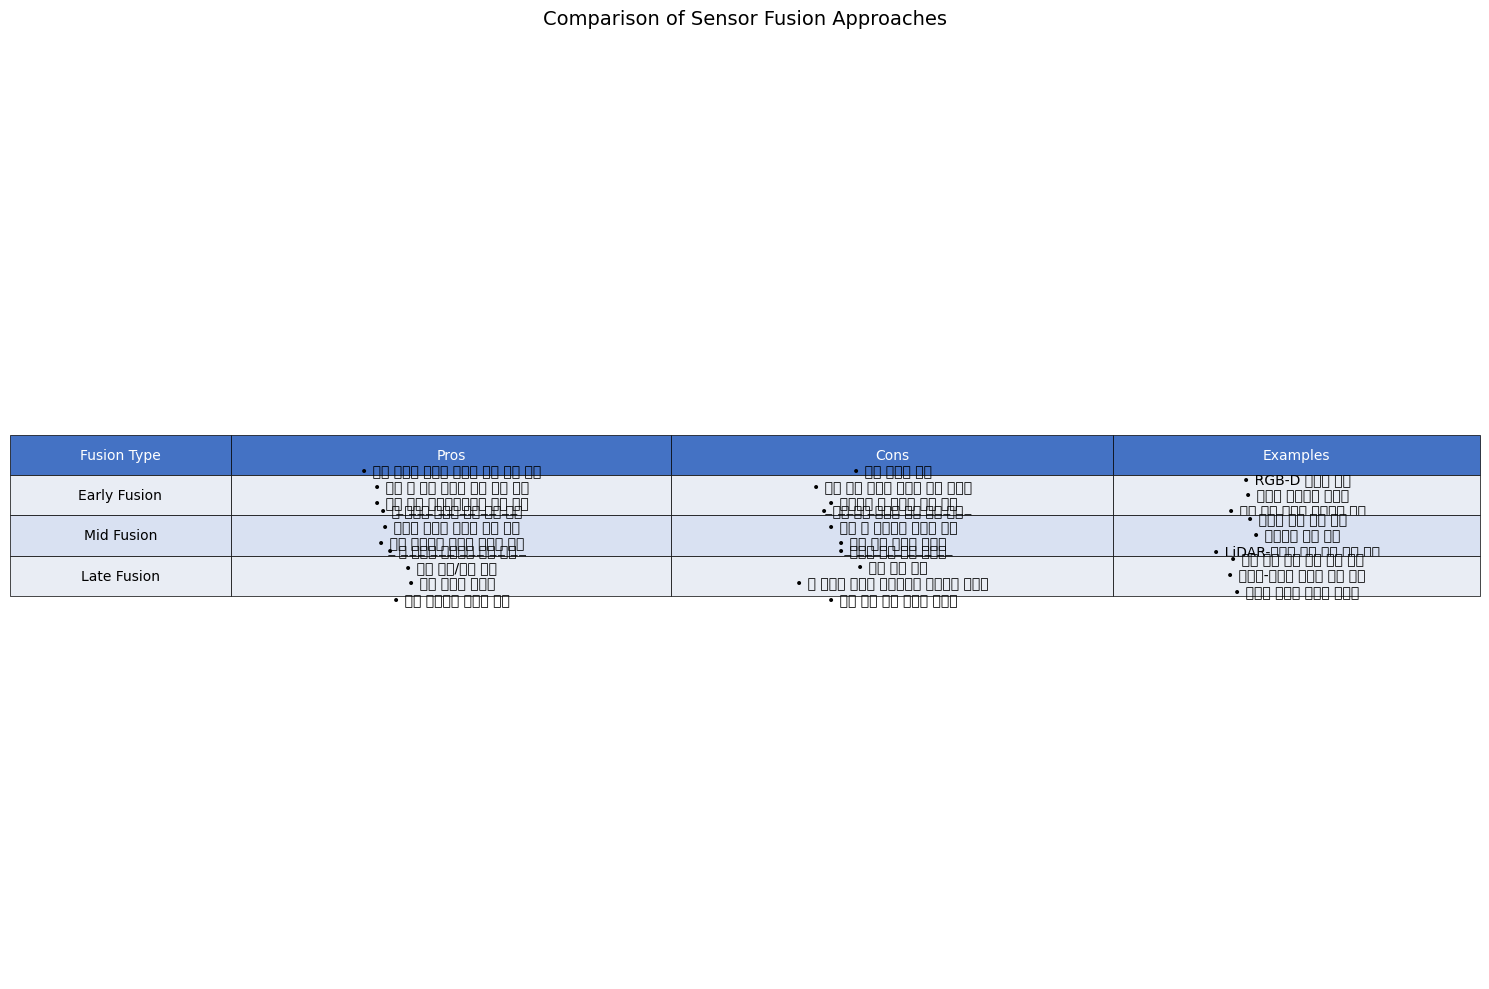

In [11]:
# 센서 융합 방식 비교 및 평가 표
fusion_comparison = {
    'Early Fusion': {
        'pros': [
            '원시 데이터 수준의 완전한 정보 활용 가능',
            '센서 간 상호 보완적 특성 직접 활용',
            '단일 처리 파이프라인으로 구현 간단',
            '각 센서의 약점 직접 보완 가능'
        ],
        'cons': [
            '센서 동기화 필수',
            '서로 다른 특성의 데이터 결합 어려움',
            '처리해야 할 데이터 양이 많음',
            '한 센서의 노이즈가 전체 성능에 영향'
        ],
        'examples': [
            'RGB-D 데이터 생성',
            '포인트 클라우드 컬러링',
            '다중 센서 포인트 클라우드 병합'
        ]
    },
    'Mid Fusion': {
        'pros': [
            '각 센서의 고유한 특징 추출 활용',
            '다양한 특성의 데이터 융합 가능',
            '특징 수준에서 노이즈 필터링 가능',
            '각 센서의 장점을 결합한 특징 생성'
        ],
        'cons': [
            '특징 추출 방법에 따라 성능 변동',
            '특징 간 상관관계 모델링 복잡',
            '최적 특징 선택의 어려움',
            '각 센서별 특징 추출기 필요'
        ],
        'examples': [
            '딥러닝 기반 특징 융합',
            '멀티모달 특징 학습',
            'LiDAR-카메라 특징 융합 객체 검출'
        ]
    },
    'Late Fusion': {
        'pros': [
            '각 센서별 독립적인 처리 가능',
            '센서 추가/제거 용이',
            '센서 고장에 강인함',
            '기존 알고리즘 재활용 가능'
        ],
        'cons': [
            '저수준 정보 활용 어려움',
            '중복 계산 발생',
            '각 센서의 약점을 근본적으로 극복하기 어려움',
            '결정 융합 규칙 설계의 어려움'
        ],
        'examples': [
            '다중 센서 객체 검출 결과 융합',
            '레이더-카메라 트래킹 결과 융합',
            '다양한 클래스 분류기 앙상블'
        ]
    }
}

# 표 형태로 시각화
def visualize_fusion_comparison(comparison_data):
    """센서 융합 방식 비교 표 시각화"""
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.axis('tight')
    ax.axis('off')
    
    # 표 헤더
    headers = ['Fusion Type', 'Pros', 'Cons', 'Examples']
    
    # 표 데이터 준비
    table_data = []
    for fusion_type, data in comparison_data.items():
        pros = '\n'.join([f"• {item}" for item in data['pros']])
        cons = '\n'.join([f"• {item}" for item in data['cons']])
        examples = '\n'.join([f"• {item}" for item in data['examples']])
        table_data.append([fusion_type, pros, cons, examples])
    
    # 표 생성
    table = ax.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
    
    # 표 스타일 설정
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # 각 셀 너비 조정
    for i, width in enumerate([0.15, 0.3, 0.3, 0.25]):
        for j in range(len(table_data) + 1):
            cell = table[(j, i)]
            cell.set_width(width)
            
            # 헤더 셀 색상 설정
            if j == 0:
                cell.set_facecolor('#4472C4')
                cell.set_text_props(color='white')
            else:
                # 행 별 색상 번갈아 설정
                if j % 2 == 0:
                    cell.set_facecolor('#D9E1F2')
                else:
                    cell.set_facecolor('#E9EDF4')
    
    plt.title('Comparison of Sensor Fusion Approaches', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig('fusion_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

# 센서 융합 방식 비교 표 시각화
visualize_fusion_comparison(fusion_comparison)

## 11. 요약 및 결론

이 노트북에서는 자율주행을 위한 다양한 센서 융합 기법을 살펴보고 구현해보았습니다.

주요 학습 내용:

1. 센서 융합의 기본 개념과 필요성
2. 초기/중기/후기 융합 방식의 차이점과 특징
3. RGB-D 데이터 생성을 통한 초기 융합 구현
4. 특징 추출 및 융합을 통한 중기 융합 구현
5. 객체 검출 결과 융합을 통한 후기 융합 구현
6. 3D-2D 융합 파이프라인 구현
7. 다양한 센서 융합 방식의 장단점 비교 및 평가

센서 융합은 자율주행 시스템의 인지 성능을 향상시키는 핵심 기술입니다. 각 센서의 장점을 결합하고 단점을 완하여 더 정확하고 신뢰성 있는 환경 인식을 가능하게 합니다.

## 다음 단계

- 시간적 센서 융합 구현 (여러 프레임에 걸친 센서 데이터 융합)
- 딥러닝 기반 멀티모달 융합 아키텍처 연구
- 불확실성을 고려한 센서 융합 방법 연구
- 다양한 조건(날씨, 조명 등)에서의 센서 융합 성능 평가
